# Shielding Calculation

This workbook is intended to be an OpenMC implementation of the MCNP example problem shield05.

A Cf-252 source generating $3\times10^8$ neutrons per hour is placed next to a shield.  The shield is layered - iron / water / iron. 

A flux tally should be placed at the far surface of the shield with appropriate multipliers to get rem/hr.

In [1]:
import openmc
import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np

In [2]:
air = openmc.Material(name="air");
air.add_element('O',0.2);
air.add_element('N',0.8);
air.set_density('g/cm3',1.3e-3);

iron = openmc.Material(name = "iron");
iron.add_element('Fe',1.0);
iron.set_density('g/cm3',7.874);

water = openmc.Material(name = "water");
water.add_element('O',1);
water.add_element('H',2);
water.set_density('g/cm3',1.0);
water.add_s_alpha_beta('c_H_in_H2O');

materials = openmc.Materials([air,iron,water]);


In [3]:
domain = openmc.model.RectangularParallelepiped(-10,140,
                                               -100, 100,
                                               -100,100,
                                               boundary_type='vacuum');

p1 = openmc.XPlane(x0=0.0);
p2 = openmc.XPlane(x0=10.0);
p3 = openmc.XPlane(x0=20.0);
p4 = openmc.XPlane(x0=40.0);
tally_plane = openmc.XPlane(x0=139.9); 

air_left = openmc.Cell();
air_left.region = -domain & -p1;
air_left.fill = air;

shield1 = openmc.Cell();
shield1.region = -domain & +p1 & -p2;
shield1.fill = iron;

shield2 = openmc.Cell();
shield2.region = -domain & +p2 & -p3;
shield2.fill = water;

shield3 = openmc.Cell();
shield3.region = -domain & +p3 & -p4;
shield3.fill = iron;

air_right = openmc.Cell();
air_right.region = -domain & +p4 & -tally_plane;
air_right.fill = air;

tally_cell = openmc.Cell();
tally_cell.region = -domain & +tally_plane;
tally_cell.fill = air;

root_univ = openmc.Universe();
root_univ.add_cells([air_left,shield1,shield2,shield3,
                     air_right,tally_cell]);

geometry = openmc.Geometry();
geometry.root_universe = root_univ;

materials.export_to_xml();
geometry.export_to_xml();




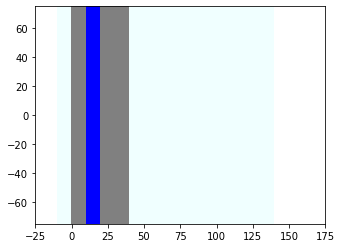

In [4]:
colors = {};
colors[air]='azure';
colors[water] = 'blue';
colors[iron] = 'gray';

root_univ.plot(origin=(75,0,0),width=(200,150),
               color_by='material',colors=colors);

In [5]:
# add a tally to estimate the dose at the right side of the domain
flux = openmc.Tally(name='flux');

energy,dose = openmc.data.dose_coefficients('neutron','AP');
dose_filter = openmc.EnergyFunctionFilter(energy,dose);
surface_filter = openmc.SurfaceFilter(tally_plane);
#surface_filter = openmc.SurfaceFilter(p4);
#cell_filter = openmc.CellFilter(tally_cell);


flux.filters = [dose_filter,surface_filter];
flux.scores = ['current'];

tallies = openmc.Tallies([flux]);
tallies.export_to_xml();

In [6]:
# point source at x = -5
point = openmc.stats.Point((-5.0,0,0));
energy = openmc.stats.Watt(a=1.025e6,b=2.926e-6);

source = openmc.Source(space=point,energy=energy);

settings = openmc.Settings();
settings.run_mode = 'fixed source';
settings.batches = 100;
settings.particles = 30000; #particles per generation
settings.generations_per_batch = 100; 
settings.source = source;

settings.export_to_xml();

In [7]:
openmc.run();

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [8]:
sp = openmc.StatePoint('statepoint.100.h5')
sp.tallies;

dose_t = sp.get_tally(name='flux');
dose_df = dose_t.get_pandas_dataframe()
dose_df.head()

current = dose_df['mean'];
std_dev = dose_df['std. dev.'];

source_strength = 3e8; # neutrons per second
conv_pSv_to_rem = 1e-10; # conversion of pico-sieverts to rem
time = 3600;
surf_area = 200.*200.;

current = current*conv_pSv_to_rem*source_strength*time/surf_area

print('the dose is approximately %6.4g rem/hr' % current);


the dose is approximately 0.001993 rem/hr
